## 1D Case - Figures 8b and 8d
 
 Investigation of the influence of the number of gauss points per element when computing the loss using the Gauss quadrature, on the convergence regarding the mesh size. The study has been done on fixed-mesh and on r-adapted mesh.

In [1]:
#%% Libraries import
import sys  

from HiDeNN_PDE import MeshNN, NeuROM, MeshNN_2D, MeshNN_1D
# Import pre-processing functions
import Bin.Pre_processing as pre
# Import torch librairies
import torch
import torch.nn as nn
# Import mechanical functions

from Bin.Training import Training_1D_FEM_LBFGS
#Import post processing libraries
import Post.Plots as Pplot
import time
import os
import torch._dynamo as dynamo
mps_device = torch.device("mps")
from importlib import reload  # Python 3.4+
import tomllib
import numpy as numpy
import argparse



In [2]:
# Load default configuration file (defines dimension, domain, boundary conditions, number of training iterations etc.)
Default_config_file = 'Configuration/config_1D.toml'


with open(Default_config_file, mode="rb") as f:
    config = tomllib.load(f)

* Executing job in Configuration/config_1D.toml


In [3]:
# Experiment setting: Gauss quadrature
# Tested variants: 6 mesh resolutions, 3-,4- and 5-point quadrature rule, fixed and r-adaptive mesh

mesh_resolution = [10,21,41,80,160,324]
quadrature_points = [3,4,5]

setting = ["fixed", "r-adaptive"]

config["solver"]["IntegralMethod"] = "Gaussian_quad"

loss_u = numpy.zeros((len(setting),len(mesh_resolution), len(quadrature_points)))
loss_grad = numpy.zeros((len(setting),len(mesh_resolution), len(quadrature_points)))

for q in range(len(quadrature_points)):
    config["interpolation"]["n_integr_points"] = quadrature_points[q]
    for set in range(len(setting)):
        if setting[set] == "fixed":
            config["solver"]["FrozenMesh"] = True
        elif setting[set] == "r-adaptive":
            config["solver"]["FrozenMesh"] = False

        for res in range(len(mesh_resolution)):

            config["interpolation"]["np"] = mesh_resolution[res]
            

            # Load parameters
            if config["interpolation"]["dimension"] == 1:
                Mat = pre.Material(             flag_lame = True,                               # If True should input lmbda and mu instead of E and nu
                                                coef1     = config["material"]["E"],            # Young Modulus
                                                coef2     = config["geometry"]["A"]             # Section area of the 1D bar
                                    )
            elif config["interpolation"]["dimension"] == 2:
                try:
                    Mat = pre.Material(         flag_lame = False,                              # If True should input lmbda and mu instead of E and nu
                                                coef1     = config["material"]["E"],            # Young Modulus
                                                coef2     = config["material"]["nu"]            # Poisson's ratio
                                    )
                except:
                    Mat = pre.Material(         flag_lame = True,                               # If True should input lmbda and mu instead of E and nu
                                                coef1     = config["material"]["lmbda"],        # First Lame's coef
                                                coef2     = config["material"]["mu"]            # Second Lame's coef
                                    )

            MaxElemSize = pre.ElementSize(
                                            dimension     = config["interpolation"]["dimension"],
                                            L             = config["geometry"]["L"],
                                            order         = config["interpolation"]["order"],
                                            np            = config["interpolation"]["np"],
                                        )

            Excluded = []

            Mesh_object = pre.Mesh( 
                                            config["geometry"]["Name"],                 # Create the mesh object
                                            MaxElemSize, 
                                            config["interpolation"]["order"], 
                                            config["interpolation"]["dimension"]
                                    )

            Mesh_object.AddBorders(config["Borders"]["Borders"])
            Mesh_object.AddBCs(                                                         # Include Boundary physical domains infos (BCs+volume)
                                            config["geometry"]["Volume_element"],
                                            Excluded,
                                            config["DirichletDictionryList"]
                                )                   

            Mesh_object.MeshGeo()                                                       # Mesh the .geo file if .msh does not exist
            Mesh_object.ReadMesh() 

            print(config["solver"]["IntegralMethod"])
            print()
            # Vtk file not necessary if not using reference element implementation
            if config["solver"]["IntegralMethod"] == "Gaussian_quad":
                Mesh_object.ExportMeshVtk1D()

            # Build the assembly weight matrix if needed
            if config["interpolation"]["dimension"] ==1 and config["solver"]["IntegralMethod"] == "Trapezoidal":
                Mesh_object.AssemblyMatrix()                                            

            if int(Mesh_object.dim) != int(Mesh_object.dimension):
                raise ValueError("The dimension of the provided geometry does not match the job dimension")

            if config["solver"]["TrainingStrategy"]=="Integral":
                match config["solver"]["IntegralMethod"]:                          
                    case "Gaussian_quad":
                        Model_FEM = MeshNN_1D(Mesh_object, config["interpolation"]["n_integr_points"])  
                    case "Trapezoidal":
                        Model_FEM = MeshNN(Mesh_object)

            if config["solver"]["TrainingStrategy"]=="Mixed":
                if config["solver"]["IntegralMethod"] == "Gaussian_quad":
                    Model_FEM = MeshNN_1D(Mesh_object, config["interpolation"]["n_integr_points"])
                    Model_test = MeshNN_1D(Mesh_object, config["interpolation"]["n_integr_points"])  
                    Model_test.Freeze_Mesh()

            # Default setting
            Model_FEM.Freeze_Mesh()
            Model_FEM.UnFreeze_FEM()

            if not config["solver"]["FrozenMesh"]:
                Model_FEM.UnFreeze_Mesh()    

            if config["solver"]["TrainingStrategy"]=="Mixed":
                Model_FEM = Training_1D_FEM_LBFGS(Model_FEM, config, Mat, Model_test)
            else:
                Model_FEM = Training_1D_FEM_LBFGS(Model_FEM, config, Mat)

            l2_loss, l2_loss_grad = Pplot.Normalized_error_1D(Model_FEM,config,Mat)

            
            loss_u[set, res, q] = l2_loss
            loss_grad[set, res, q] = l2_loss_grad


 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Dofs:           10
Gaussian_quad


mesh.NNodes =  10
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  -0.012880413395373339
     loss_decrease =  1.0128804133953733
epoch =  2
     loss =  -0.012880413395373339
     loss_decrease =  0.0
epoch =  3
     loss =  -0.012880413395373339
     loss_decrease =  0.0
epoch =  4
     loss 

<Figure size 640x480 with 0 Axes>

Fixed :  [0.25501984 0.06688663 0.0188871  0.00491831 0.00121236 0.00515898]
Fixed :  [0.25609227 0.0668039  0.01888654 0.00491837 0.00122098 0.0031826 ]
Fixed :  [0.25615316 0.06680598 0.01888654 0.00492018 0.00122457 0.00153295]

Adapt :  [       nan 0.06747639 0.01315608 0.00487374 0.00131616 0.00039702]
Adapt :  [       nan 0.05637289 0.01308851 0.0048737  0.00124185 0.00041143]
Adapt :  [       nan 0.05694514 0.01308796 0.0048737  0.00127431 0.00049808]



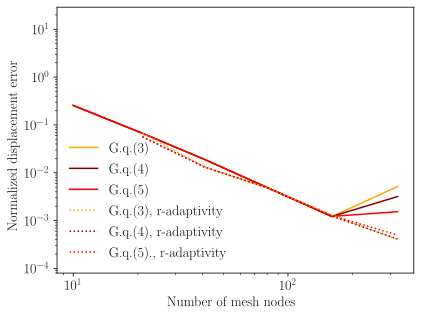

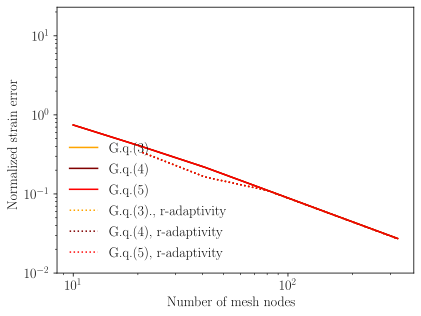

In [4]:
import matplotlib.pyplot as plt
import matplotlib

# Plot normalized displacement error

print("Fixed : ", loss_u[0,:,0])
print("Fixed : ", loss_u[0,:,1])
print("Fixed : ", loss_u[0,:,2])
print()
print("Adapt : ", loss_u[1,:,0])
print("Adapt : ", loss_u[1,:,1])
print("Adapt : ", loss_u[1,:,2])

print()

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

plt.plot(mesh_resolution, loss_u[0,:,0],'-', color = "orange", label = 'G.q.(3)')
plt.plot(mesh_resolution, loss_u[0,:,1],'-', color = "maroon", label = 'G.q.(4)')
plt.plot(mesh_resolution, loss_u[0,:,2],'-', color = "red", label = 'G.q.(5)')

plt.plot(mesh_resolution, loss_u[1,:,0],':', color = "orange", label = 'G.q.(3),  r-adaptivity')
plt.plot(mesh_resolution, loss_u[1,:,1],':', color = "maroon", label = 'G.q.(4),  r-adaptivity')
plt.plot(mesh_resolution, loss_u[1,:,2],':', color = "red", label = 'G.q.(5).,  r-adaptivity')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.00008, 29])

plt.xlabel("Number of mesh nodes")
plt.ylabel("Normalized displacement error")
plt.legend(loc="lower left", frameon=False )
plt.show()

# Plot normalized strain error

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

plt.plot(mesh_resolution, loss_grad[0,:,0],'-', color = "orange", label = 'G.q.(3)')
plt.plot(mesh_resolution, loss_grad[0,:,1],'-', color = "maroon", label = 'G.q.(4)')
plt.plot(mesh_resolution, loss_grad[0,:,2],'-', color = "red", label = 'G.q.(5)')

plt.plot(mesh_resolution, loss_grad[1,:,0],':', color = "orange", label = 'G.q.(3).,  r-adaptivity')
plt.plot(mesh_resolution, loss_grad[1,:,1],':', color = "maroon", label = 'G.q.(4),  r-adaptivity')
plt.plot(mesh_resolution, loss_grad[1,:,2],':', color = "red", label = 'G.q.(5),  r-adaptivity')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.01, 23])

plt.xlabel("Number of mesh nodes")
plt.ylabel("Normalized strain error")
plt.legend(loc="lower left", frameon=False )
plt.show()

